## KITTI-Data Object Detection
### Problem Statement
The goal of this project is to detect object from a number of visual object classes in realistic scenes. There are 7 object classes and 2 abstract classes:

1. Car, Van, Truck, Tram, Pedestrian, Person, Cyclist
2. Misc, DontCare


### 1. Import Libraries and Datasets

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline
import numpy as np
from numpy import asarray, savez_compressed, load
from math import floor
import os
from PIL import Image
#from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
%tensorflow_version 1.x
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Convolution2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import plot_model
import warnings
warnings.filterwarnings('ignore')
from keras.models import model_from_json
import json

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
path = '/content/gdrive/My Drive/AI institute_datasets/kitti-object-detection/kitti_single'
path_training = path+'/training'
path_train_images = path_training+'/image_2'
path_train_labels = path_training+'/label_2' 
img_files = os.listdir(path_train_images)
img_files.sort(key= lambda f: int(os.path.splitext(f)[0]))
label_files = os.listdir(path_train_labels)
label_files.sort(key= lambda f: int(os.path.splitext(f)[0]))


### 2. Data Exploration

The training and test data are ~6GB each (12GB in total). The data can be downloaded at http://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark .The label data provided in the KITTI dataset corresponding to a particular image includes the following fields. The labels also include 3D data which is out of scope for this project.

| Key       	| Values 	| Description                                                                                                           	|
|-----------	|--------	|-----------------------------------------------------------------------------------------------------------------------	|
| type      	| 1      	| String describing the type of object: [Car, Van, Truck, Pedestrian,Person_sitting, Cyclist, Tram, Misc or DontCare]   	|
| truncated 	| 1      	| Float from 0 (non-truncated) to 1 (truncated), where truncated refers to the object leaving image boundaries          	|
| occluded  	| 1      	| Integer (0,1,2,3) indicating occlusion state:  0 = fully visible 1 = partly occluded 2 = largely occluded 3 = unknown 	|
| alpha     	| 1      	| Observation angle of object ranging from [-pi, pi]                                                                    	|
| bbox      	| 4      	| 2D bounding box of object in the image (0-based index): contains left, top, right, bottom pixel coordinates           	|


In [0]:
print("First 10 image files and corresponding text files",'\n')
print(img_files[:10],'\n',label_files[:10],'\n','\n')
print("Number of image files in training folder = {}".format(len(img_files)))

First 10 image files and corresponding text files 

['000000.png', '000001.png', '000002.png', '000003.png', '000004.png', '000005.png', '000006.png', '000007.png', '000008.png', '000009.png'] 
 ['000000.txt', '000001.txt', '000002.txt', '000003.txt', '000004.txt', '000005.txt', '000006.txt', '000007.txt', '000008.txt', '000009.txt'] 
 

Number of image files in training folder = 7481


In [0]:
selected_file = 200 #200
temp_path = path_train_labels+'/'+label_files[selected_file]
file1 = open(temp_path,'r')
s = file1.read()
file1.close()
print(s)

Car 0.00 0 -1.57 602.62 178.85 663.95 238.07 1.61 1.66 3.20 0.64 1.80 21.40 -1.54
Car 0.00 1 -1.90 797.21 186.52 1018.27 325.26 1.43 1.50 3.38 3.55 1.63 9.34 -1.55
Misc 0.00 0 -2.07 1039.53 140.69 1095.45 193.50 2.18 1.30 1.75 19.49 0.86 30.83 -1.51
Pedestrian 0.00 0 2.71 880.69 173.34 929.34 335.38 1.63 0.41 0.33 2.98 1.64 7.50 3.07



In [0]:
def img_disp(file_name):
  img_path = path_train_images+'/'+file_name
  label_path = path_train_labels+'/'+ file_name.split('.')[0]+'.txt'
  file1 = open(label_path,'r')
  text = file1.read()
  file1.close()
  obj = []; truncated = [];occluded = []; bbox_left =[]; bbox_top =[]; bbox_right=[];bbox_bot =[]
  for item in text.splitlines():
    temp = item.split()
    obj.append(str(temp[0]));truncated.append(float(temp[1]));occluded.append(int(temp[2]))
    bbox_left.append(float(temp[4]));bbox_top.append(float(temp[5]));bbox_right.append(float(temp[6]))
    bbox_bot.append(float(temp[7]))
  image = Image.open(img_path)
  image = image.convert('RGB')
  image = asarray(image)
  fig, ax = plt.subplots(figsize=(20, 15))
  for i in range(len(obj)):
    if not (obj[i]=='DontCare' or obj[i]=='Misc'):
      ax.add_patch(Rectangle([bbox_left[i],bbox_top[i]],width = bbox_right[i]-bbox_left[i],height= bbox_bot[i]-bbox_top[i],color='red',fill = False))
      plt.text(bbox_left[i]-5,bbox_top[i]-5,obj[i],fontsize =12,color = 'red',fontweight = 'bold')
  ax.imshow(image)

img_disp(img_files[selected_file])

### 3. Scaling and Extracting objects
Original images typically have resolution of about **1300 x 400** pixels. The resolution is not fixed for the images. So scaling all images to a constant resolution is required. Here we can define desired **width** and **height** (in terms of pixels) of images as scaling parameters

In [0]:
#### Inputs
width = 1400; height = 400
selected_file = 65


In [0]:
def img_data(file_name,w=1200,h=300):
  img_path = path_train_images+'/'+file_name
  image = Image.open(img_path)
  image = image.convert('RGB')
  array_image = asarray(image)
  image = image.resize((w,h))
  orig_img_h,orig_img_w = array_image.shape[0],array_image.shape[1]
  scale_y, scale_x = h/orig_img_h,w/orig_img_w # scaling parameters
  image = asarray(image)
  label_path = path_train_labels+'/'+ file_name.split('.')[0]+'.txt'
  file1 = open(label_path,'r')
  text = file1.read()
  file1.close()
  obj = []; truncated = [];occluded = []; bbox_left =[]; bbox_top =[]; bbox_right=[];bbox_bot =[]
  for item in text.splitlines():
    temp = item.split()
    obj.append(str(temp[0]));truncated.append(float(temp[1]));occluded.append(int(temp[2]))
    bbox_left.append(float(temp[4]));bbox_top.append(float(temp[5]));bbox_right.append(float(temp[6]))
    bbox_bot.append(float(temp[7]))
  bbox_obj = np.zeros((len(obj),4))
  ### Rescale bounding boxes
  for i in range(len(obj)):
    bbox_obj[i]= bbox_left[i]*scale_x,bbox_top[i]*scale_y,(bbox_right[i]-bbox_left[i])*scale_x,(bbox_bot[i]-bbox_top[i])*scale_y
  print(bbox_obj[1,2])
  fig, ax = plt.subplots(figsize=(20, 15))
  for i in range(len(obj)):
    if not (obj[i]=='DontCare' or obj[i]=='Misc'):
      ax.add_patch(Rectangle(bbox_obj[i,:2],width = bbox_obj[i,2],height= bbox_obj[i,3],color='red',fill = False))
      plt.text(bbox_obj[i,0]-5,bbox_obj[i,1]-5,obj[i],fontsize =12,color = 'red',fontweight = 'bold')
  ax.imshow(asarray(image))
  return image

170.1033925686591


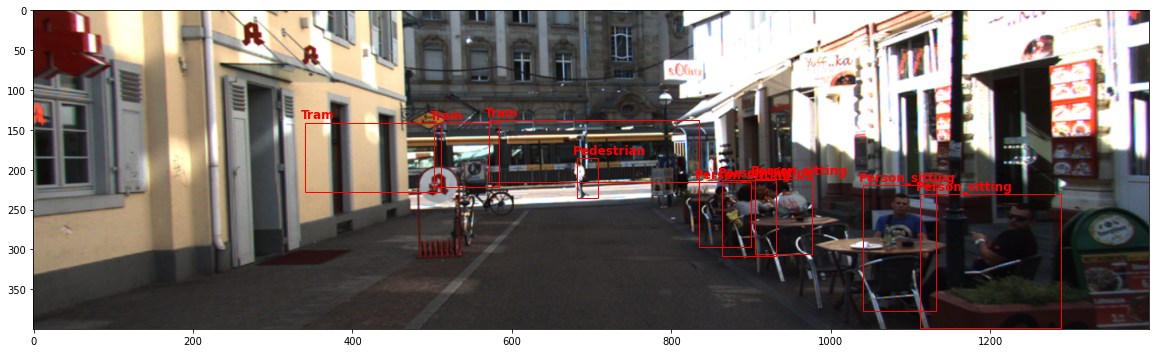

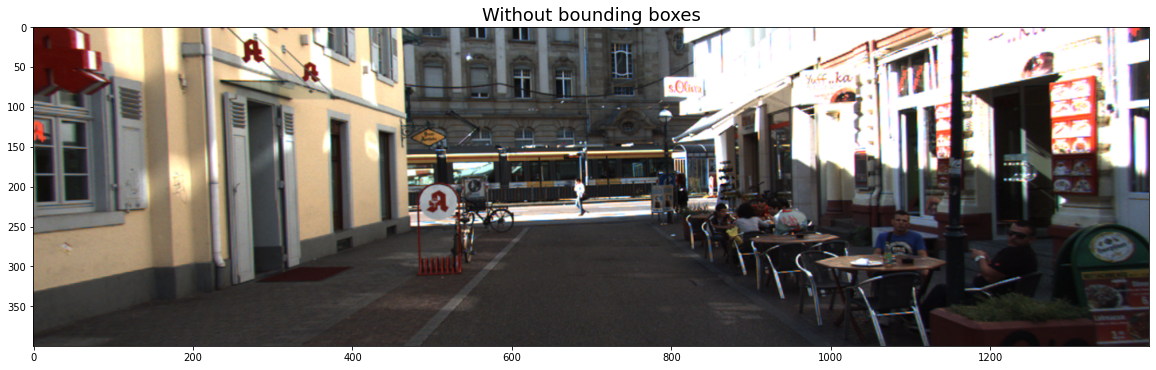

In [0]:
img = img_data(img_files[selected_file],width,height)
plt.subplots(figsize=(20, 15))
plt.title("Without bounding boxes",fontsize = 18)
plt.imshow(img)

Aim is to extract the individual objects from each image in the training set. 

In [0]:
objects = ['Car', 'Van', 'Truck','Pedestrian', 'Person_sitting', 'Cyclist', 'Tram','Misc','DontCare']
object_width, object_height = 128,128

In [0]:
def extract_features(file_name,h= 300,w=1200):
  img_path = path_train_images+'/'+file_name
  image = Image.open(img_path)
  image = image.convert('RGB')
  array_image = asarray(image)
  image = image.resize((w,h))
  image = asarray(image)
  orig_img_h,orig_img_w = array_image.shape[0],array_image.shape[1]
  scale_y, scale_x = h/orig_img_h,w/orig_img_w
  label_path = path_train_labels+'/'+ file_name.split('.')[0]+'.txt'
  file1 = open(label_path,'r')
  text = file1.read()
  file1.close()
  obj = []; truncated = [];occluded = []; bbox_left =[]; bbox_top =[]; bbox_right=[];bbox_bot =[]
  for item in text.splitlines():
    temp = item.split()
    if not (str(temp[0])=='DontCare'):
      obj.append(str(temp[0]));truncated.append(float(temp[1]));occluded.append(int(temp[2]))
      bbox_left.append(float(temp[4]));bbox_top.append(float(temp[5]));bbox_right.append(float(temp[6]))
      bbox_bot.append(float(temp[7]))
  #bbox_obj = np.zeros((len(obj),4))
  imgs_array =[]
  for i in range(len(obj)):
    #if not (obj[i]=='DontCare' or obj[i]=='Misc'):
    left,top,right,bottom= floor(bbox_left[i]*scale_x),floor(bbox_top[i]*scale_y),floor(bbox_right[i]*scale_x),floor(bbox_bot[i]*scale_y)
    img_dat = Image.fromarray(image[top:bottom,left:right],'RGB')
    img_dat = img_dat.resize((object_width,object_height)) # Object scaling
    img_dat = asarray(img_dat)
    imgs_array.append(img_dat)
  return imgs_array, obj

The following code extracts single object from all the 7481 training images and save the images and objects as numpy array. It took nearly 4 hours to extract objects.

In [0]:
# img_data = [];object_data = []
# image_count = len(img_files)
# for i in range(image_count):
#   if i%100 == 0:
#     print("Iteration number = ",i)
#   file_name = img_files[i]
#   img_array, objj = extract_features(file_name)
#   for count,obj in enumerate(objj):
#     object_data.append(obj)
#     img_data.append(img_array[count])
# X = asarray(img_data)
# y = asarray(object_data)
# savez_compressed(path+'/Numpy_data_wholedata_128by128',X,y)

In [0]:
#data = load(path+'/Numpy_data_wholedata_128by128.npz')
data = load("/content/gdrive/My Drive/AI institute_datasets/kitti-object-detection/kitti_single/Numpy_data_wholedata_128by128.npz")
X,y = data['arr_0'],data['arr_1']
#img_data = X.tolist()
object_data = y.tolist()
print(X.shape,y.shape)


(40570, 128, 128, 3) (40570,)


In [0]:
print("Total number of Objects extracted = ",len(object_data),'\n')
Counter(object_data)

Total number of Objects extracted =  40570 



Counter({'Car': 28742,
         'Cyclist': 1627,
         'Misc': 973,
         'Pedestrian': 4487,
         'Person_sitting': 222,
         'Tram': 511,
         'Truck': 1094,
         'Van': 2914})

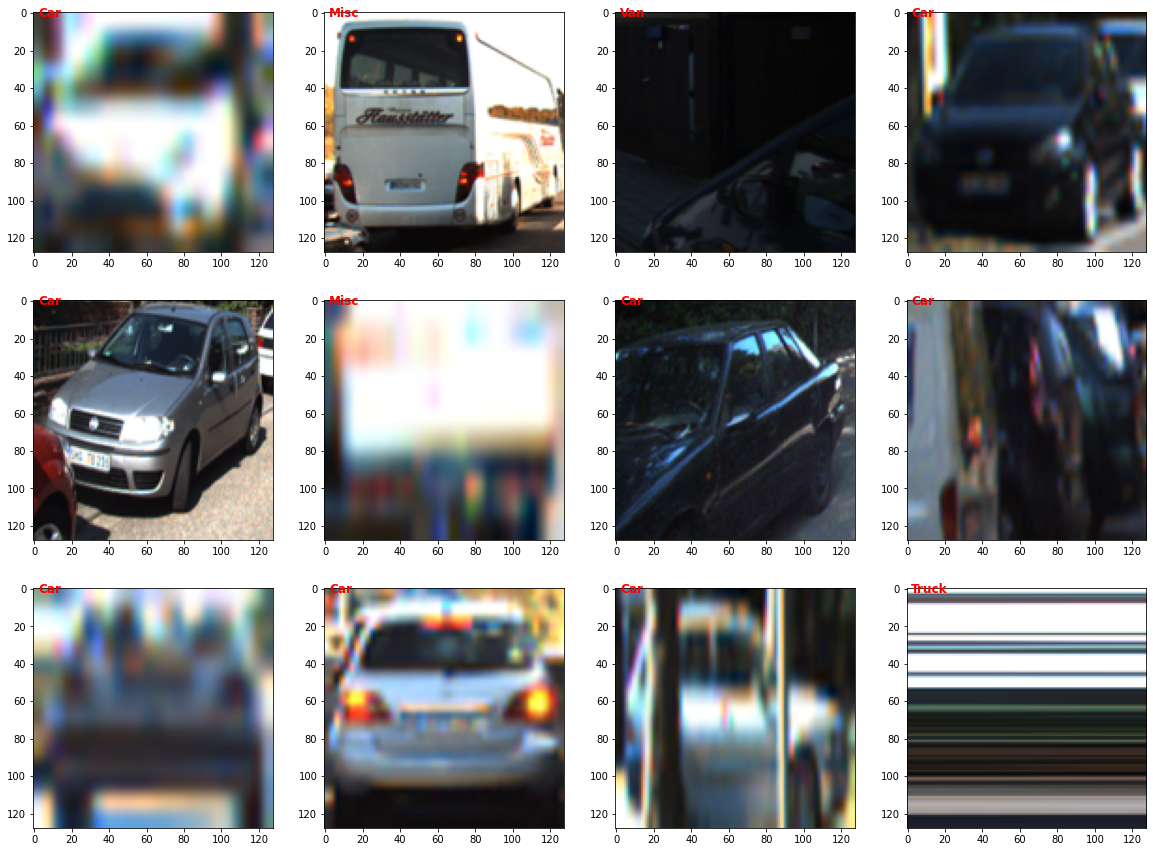

In [0]:
disp_row,disp_col = 3,4
fig, ax = plt.subplots(disp_row,disp_col,figsize=(20, 15))
#text = plt.text(2,2,'temp',fontsize =12,color = 'red',fontweight = 'bold')
for i in range(disp_row):
  for j in range(disp_col):
    t = np.random.randint(low=0,high=len(object_data))
    #plt.cla()
    ax[i,j].text(2,2,object_data[t],fontsize =12,color = 'red',fontweight = 'bold')
    ax[i,j].imshow(X[t])
    #plt.tight_layout()
    #text.set_text()


## 4. Prerequisites to CNN 

In [0]:
### One hot encoding object labels
oh_encoder = OneHotEncoder()
y = pd.DataFrame(y)
oh_encoder.fit(y)
y = oh_encoder.transform(y)
y = y.toarray()

In [0]:
# ## Splitting data into test, train and validation and scaling
# i = int(0.7 * len(X)) 
# j = int(0.8 * len(X))
# train_X = X[:i]/255.
# val_X = X[i:j]/255
# test_X = X[j:]/255.
# train_y = y[:i]
# val_y = y[i:j]
# test_y = y[j:]

In [0]:
X = X/255. ; 
from sklearn.model_selection import train_test_split
train_X, test_X, train_y,test_y = train_test_split(X,y,stratify = y,test_size = 0.2)

In [0]:
i = int(0.9 * len(train_X)) 
val_X = train_X[i:]
train_X = train_X[:i]
val_y = train_y[i:]
train_y = train_y[:i]


In [0]:
print("Shape of training array of Image data: ",train_X.shape)
print("Shape of testing array of Image data: ",test_X.shape)
print("Shape of validation array of Image data: ",val_X.shape)
print("Shape of training array of Labels: ",train_y.shape)
print("Shape of testing array of Labels: ",test_y.shape)
print("Shape of validation array of Labels: ",val_y.shape)

Shape of training array of Image data:  (29210, 64, 64, 3)
Shape of testing array of Image data:  (8114, 64, 64, 3)
Shape of validation array of Image data:  (3246, 64, 64, 3)
Shape of training array of Labels:  (29210, 8)
Shape of testing array of Labels:  (8114, 8)
Shape of validation array of Labels:  (3246, 8)


## 5. CNN model 

In [0]:
filter_size = 3
pool_size = 2

model = Sequential([
        Convolution2D(64, 6, 6, input_shape=train_X.shape[1:], dim_ordering='tf', activation='relu'), 
        MaxPooling2D(pool_size=(pool_size, pool_size)), 
        Convolution2D(128, filter_size, filter_size, dim_ordering='tf', activation='relu'), 
        MaxPooling2D(pool_size=(pool_size, pool_size)), 
        Convolution2D(256, filter_size, filter_size, dim_ordering='tf', activation='relu'), 
        MaxPooling2D(pool_size=(pool_size, pool_size)), 
        Convolution2D(256, filter_size, filter_size, dim_ordering='tf', activation='relu'), 
        MaxPooling2D(pool_size=(pool_size, pool_size)), 
        Flatten(), 
        Dropout(0.4), 
        Dense(512, activation='relu'), 
        Dropout(0.4), 
        #Dense(128, activation='relu'), 
        #Dropout(0.4), 
        Dense(y.shape[-1])#,activation = 'softmax'
    ])

#model.compile('adadelta', 'mse')
from keras.optimizers import SGD
#opt = SGD(lr=0.01)
model.compile(loss= 'mse',optimizer='adadelta',metrics =['accuracy'])
model.summary()


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 59, 59, 64)        6976      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 27, 27, 128)       73856     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 13, 128)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 11, 11, 256)       295168    
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 5, 5, 256)         0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 3, 3, 256)        

In [0]:
filter_size = 3
pool_size = 2

model_128 = Sequential([
        Convolution2D(128, 6, 6, input_shape=train_X.shape[1:], dim_ordering='tf', activation='relu'), 
        MaxPooling2D(pool_size=(pool_size, pool_size)), 
        Convolution2D(256, filter_size, filter_size, dim_ordering='tf', activation='relu'), 
        MaxPooling2D(pool_size=(pool_size, pool_size)), 
        Convolution2D(512, filter_size, filter_size, dim_ordering='tf', activation='relu'), 
        MaxPooling2D(pool_size=(pool_size, pool_size)), 
        Convolution2D(1024, filter_size, filter_size, dim_ordering='tf', activation='relu'), 
        MaxPooling2D(pool_size=(pool_size, pool_size)), 
        Flatten(), 
        Dropout(0.4), 
        Dense(512, activation='relu'), 
        Dropout(0.4), 
        #Dense(128, activation='relu'), 
        #Dropout(0.4), 
        Dense(y.shape[-1])#,activation = 'softmax'
    ])

#model.compile('adadelta', 'mse')
from keras.optimizers import SGD
#opt = SGD(lr=0.01)
model.compile(loss= 'mse',optimizer='adadelta',metrics =['accuracy'])
model.summary()

In [0]:
batch_size = 1000;epochs =100
history = model.fit(train_X,train_y,batch_size=batch_size,epochs=epochs,validation_data=(val_X,val_y),verbose=1)

Train on 29210 samples, validate on 3246 samples
Epoch 1/100
29210/29210 [==============================] - 6s 210us/step - loss: 0.0724 - acc: 0.6866 - val_loss: 0.0578 - val_acc: 0.7138
Epoch 2/100
29210/29210 [==============================] - 5s 178us/step - loss: 0.0606 - acc: 0.7078 - val_loss: 0.0544 - val_acc: 0.7138
Epoch 3/100
29210/29210 [==============================] - 5s 177us/step - loss: 0.0581 - acc: 0.7079 - val_loss: 0.0538 - val_acc: 0.7138
Epoch 4/100
29210/29210 [==============================] - 5s 177us/step - loss: 0.0559 - acc: 0.7094 - val_loss: 0.0547 - val_acc: 0.7141
Epoch 5/100
29210/29210 [==============================] - 5s 178us/step - loss: 0.0544 - acc: 0.7141 - val_loss: 0.0506 - val_acc: 0.7200
Epoch 6/100
29210/29210 [==============================] - 5s 177us/step - loss: 0.0533 - acc: 0.7216 - val_loss: 0.0532 - val_acc: 0.7187
Epoch 7/100
29210/29210 [==============================] - 5s 178us/step - loss: 0.0515 - acc: 0.7324 - val_loss: 0.0

Saving and loading model

In [0]:
from keras.models import model_from_json
model_json = model.to_json()
#model_json = os.path.join(path,model_json)
with open(os.path.join(path,"model.json"), "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(path+"/model.h5")

hist_df = pd.DataFrame(history.history) 
with open(os.path.join(path,'history.json'), mode='w') as f:
    hist_df.to_json(f)
print("Saved model to disk")

Saved model to disk


In [0]:
json_file = open(path+'/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model1 = model_from_json(loaded_model_json)
# load weights into new model
model1.load_weights(path+"/model.h5")
print("Loaded model from disk")
history = pd.read_json(path+'/history.json')

Loaded model from disk


8114/8114 [==============================] - 2s 209us/step
Testing accuracy =  0.8920384520140957 
 Training loss =  0.020599946165712178 


['loss', 'acc']


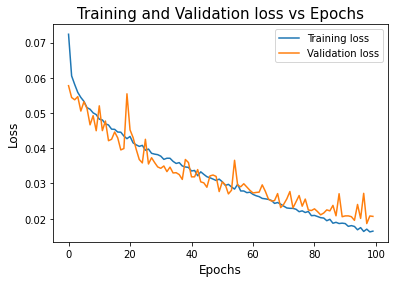

Text(0, 0.5, 'Accuracy')

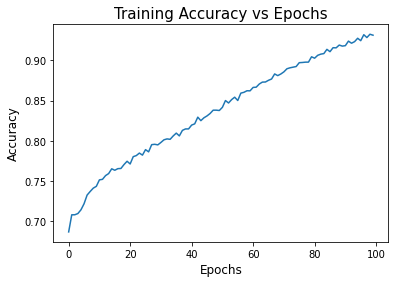

In [0]:
model1.compile(loss= 'mse',optimizer='adadelta',metrics =['accuracy'])
acc = model1.evaluate(test_X, test_y,verbose=1)
print('Testing accuracy = ',acc[1],'\n', "Training loss = ", acc[0],'\n\n')
print(model1.metrics_names)
plot_model(model1,to_file='model.png')

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Training and Validation loss vs Epochs', fontsize = 15)
plt.xlabel('Epochs',fontsize = 12)
plt.ylabel('Loss',fontsize = 12)
plt.legend(['Training loss', 'Validation loss'], loc='upper right', bbox_to_anchor=(1, 1))
plt.show()
#plt.plot(history.history['acc'])
plt.plot(history['acc'])
plt.title('Training Accuracy vs Epochs', fontsize = 15)
plt.xlabel('Epochs',fontsize = 12)
plt.ylabel('Accuracy',fontsize = 12)

## 6. Final Results

In [0]:
lab = oh_encoder.get_feature_names().tolist()
lab = [item.split('_')[1] for item in lab]
dict_lab = {i:lab[i] for i in range(len(lab))}
print(dict_lab,'\n')
predicted_classes = model1.predict_classes(test_X)
print("Predicted classes")
print(Counter(predicted_classes))

{0: 'Car', 1: 'Cyclist', 2: 'Misc', 3: 'Pedestrian', 4: 'Person', 5: 'Tram', 6: 'Truck', 7: 'Van'} 

Predicted classes
Counter({0: 6466, 3: 844, 7: 326, 1: 250, 6: 146, 5: 62, 2: 20})


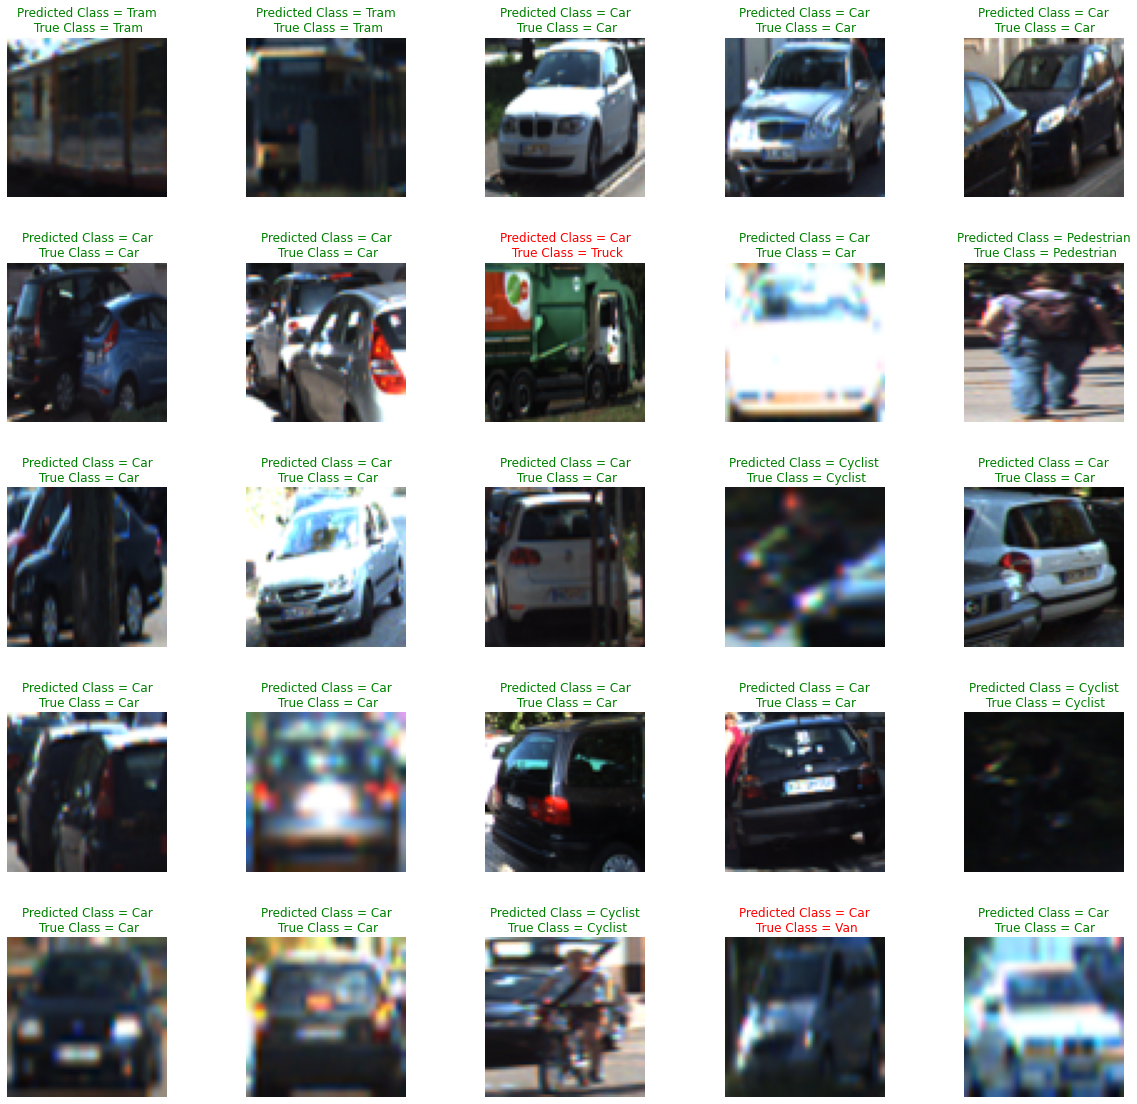

In [0]:
s = oh_encoder.inverse_transform(test_y)
L = 5
W = 5
fig, axes = plt.subplots(L, W, figsize = (20,20))
axes = axes.ravel() # 

for i in np.arange(0, L * W):
    ind = np.random.randint(0,len(predicted_classes)-1)  
    axes[i].imshow(test_X[ind])
    if lab[predicted_classes[ind]] == s[ind][0]:
      color_title = 'g'
    else:
      color_title = 'r'
    axes[i].set_title(f"Predicted Class = {lab[predicted_classes[ind]]}\n True Class = {s[ind][0]}", color=color_title)
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)